<a href="https://colab.research.google.com/github/paglababadhaka/deeplearning-architecture-evalutation/blob/main/evaluting_deeplearning_architectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What we think the curve might look like

Upload the absorption CSV file:


Saving csv_a_0_b_30_c_2.csv to csv_a_0_b_30_c_2.csv


<function matplotlib.pyplot.grid(visible: 'bool | None' = None, which: "Literal['major', 'minor', 'both']" = 'major', axis: "Literal['both', 'x', 'y']" = 'both', **kwargs) -> 'None'>

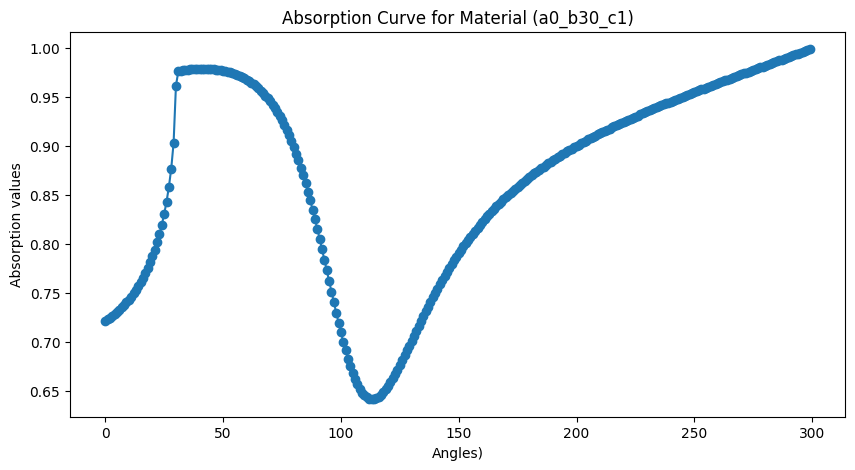

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
import io


print("Upload the absorption CSV file:")
uploaded = files.upload()
filename = list(uploaded.keys())[0]


df = pd.read_csv(io.BytesIO(uploaded[filename]))


if df.iloc[:, -1].isna().all():
    df = df.iloc[:, :-1]


row_idx = 0


row_values = df.iloc[row_idx, :].values


try:
    x_values = pd.to_numeric(df.columns)
except:
    x_values = range(len(row_values))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(x_values, row_values, marker='o')
plt.title(f'Absorption Curve for Material (a0_b30_c1)')
plt.xlabel('Angles)')
plt.ylabel('Absorption values')
plt.grid

# CNN

In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

%matplotlib inline

from google.colab import files
uploaded = files.upload()

filename = list(uploaded.keys())[0]
print(f"Uploaded file: {filename}")

Saving csv_a_0_b_30_c_1.csv to csv_a_0_b_30_c_1.csv
Uploaded file: csv_a_0_b_30_c_1.csv


In [ ]:
# Load CSV
df = pd.read_csv(filename)
print("Original shape:", df.shape)

Original shape: (3, 301)


In [ ]:
# Remove last column (contains NaNs)
df = df.iloc[:, :-1]
print("Shape after removing last column:", df.shape)

Shape after removing last column: (3, 300)


In [ ]:
# Use new last column as target
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values.astype(float)

In [ ]:
# Scale features and target
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1,1)).flatten()

In [ ]:
# Reshape X for CNN
X_scaled = X_scaled.reshape(-1, 1, X_scaled.shape[1])
print("Reshaped features:", X_scaled.shape)

Reshaped features: (3, 1, 299)


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [ ]:
# Dataset class
class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = RegressionDataset(X_train, y_train)
test_dataset = RegressionDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
# CNN Regression Model
class CNNRegression(nn.Module):
    def __init__(self, input_features):
        super(CNNRegression, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(32 * (input_features // 2), 128)
        self.fc2 = nn.Linear(128, 1)
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x.squeeze(1)

input_features = X_scaled.shape[2]
model = CNNRegression(input_features)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# Training loop
num_epochs = 30
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)

    avg_train_loss = running_train_loss / len(train_dataset)

    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_test_loss += loss.item() * inputs.size(0)

    avg_test_loss = running_test_loss / len(test_dataset)

    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.6f} - Test Loss: {avg_test_loss:.6f}")


Epoch 1/30 - Train Loss: 0.896465 - Test Loss: 1.218259
Epoch 2/30 - Train Loss: 0.841059 - Test Loss: 1.222918
Epoch 3/30 - Train Loss: 0.757858 - Test Loss: 1.228577
Epoch 4/30 - Train Loss: 0.757480 - Test Loss: 1.238938
Epoch 5/30 - Train Loss: 0.678776 - Test Loss: 1.246171
Epoch 6/30 - Train Loss: 0.602183 - Test Loss: 1.253356
Epoch 7/30 - Train Loss: 0.733077 - Test Loss: 1.257478
Epoch 8/30 - Train Loss: 0.574150 - Test Loss: 1.256599
Epoch 9/30 - Train Loss: 0.543758 - Test Loss: 1.253046
Epoch 10/30 - Train Loss: 0.523394 - Test Loss: 1.246145
Epoch 11/30 - Train Loss: 0.512413 - Test Loss: 1.237364
Epoch 12/30 - Train Loss: 0.489832 - Test Loss: 1.226436
Epoch 13/30 - Train Loss: 0.320649 - Test Loss: 1.214182
Epoch 14/30 - Train Loss: 0.435978 - Test Loss: 1.200159
Epoch 15/30 - Train Loss: 0.337354 - Test Loss: 1.185425
Epoch 16/30 - Train Loss: 0.164548 - Test Loss: 1.168424
Epoch 17/30 - Train Loss: 0.356354 - Test Loss: 1.149646
Epoch 18/30 - Train Loss: 0.319955 - Tes

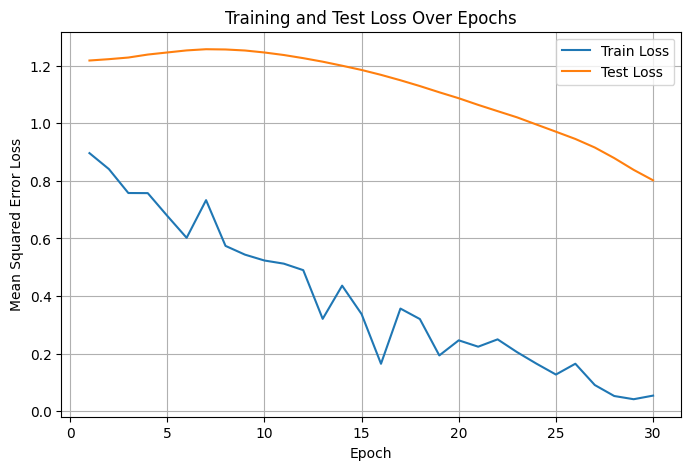

In [ ]:
# Plot
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Prediction on one test sample (inverse scaled)
model.eval()
with torch.no_grad():
    sample_input = torch.tensor(X_test[0].reshape(1,1,-1), dtype=torch.float32)
    pred_scaled = model(sample_input).item()
    pred_original = scaler_y.inverse_transform(np.array([[pred_scaled]]))[0,0]
    actual_original = scaler_y.inverse_transform(y_test[0].reshape(1,-1))[0,0]
    print(f"Predicted value (original scale): {pred_original:.4f}")
    print(f"Actual value (original scale): {actual_original:.4f}")

Predicted value (original scale): 0.9989
Actual value (original scale): 0.9991


# FNN (Fully Connected Neural Network) [Chat GPT]

In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

%matplotlib inline

from google.colab import files
uploaded = files.upload()

filename = list(uploaded.keys())[0]
print(f"Uploaded file: {filename}")

Saving csv_a_0_b_30_c_1.csv to csv_a_0_b_30_c_1.csv
Uploaded file: csv_a_0_b_30_c_1.csv


In [ ]:
# Load data
df = pd.read_csv(filename)
print("Original shape:", df.shape)

Original shape: (3, 301)


In [ ]:
# Remove last column (NaN column)
df = df.iloc[:, :-1]
print("Shape after removing last column:", df.shape)

Shape after removing last column: (3, 300)


In [ ]:
# Features and target (new last column)
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values.astype(float)

In [ ]:
# Standardize features and target
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1,1)).flatten()

print("Feature shape:", X_scaled.shape)
print("Target shape:", y_scaled.shape)

Feature shape: (3, 299)
Target shape: (3,)


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)


In [ ]:
# Dataset class
class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = RegressionDataset(X_train, y_train)
test_dataset = RegressionDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [ ]:
# Define Fully Connected Neural Network (FNN) model
class FNNRegression(nn.Module):
    def __init__(self, input_dim):
        super(FNNRegression, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(1)

input_dim = X_scaled.shape[1]
model = FNNRegression(input_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [ ]:
# Training loop
num_epochs = 30
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)
    avg_train_loss = running_train_loss / len(train_dataset)

    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_test_loss += loss.item() * inputs.size(0)
    avg_test_loss = running_test_loss / len(test_dataset)

    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.6f} - Test Loss: {avg_test_loss:.6f}")


Epoch 1/30 - Train Loss: 1.115107 - Test Loss: 1.245842
Epoch 2/30 - Train Loss: 0.748518 - Test Loss: 1.244256
Epoch 3/30 - Train Loss: 0.738654 - Test Loss: 1.239416
Epoch 4/30 - Train Loss: 0.668133 - Test Loss: 1.234510
Epoch 5/30 - Train Loss: 0.725831 - Test Loss: 1.228835
Epoch 6/30 - Train Loss: 0.684290 - Test Loss: 1.223119
Epoch 7/30 - Train Loss: 0.579166 - Test Loss: 1.217142
Epoch 8/30 - Train Loss: 0.672543 - Test Loss: 1.212379
Epoch 9/30 - Train Loss: 0.547472 - Test Loss: 1.208169
Epoch 10/30 - Train Loss: 0.453642 - Test Loss: 1.203774
Epoch 11/30 - Train Loss: 0.289494 - Test Loss: 1.198896
Epoch 12/30 - Train Loss: 0.397783 - Test Loss: 1.194355
Epoch 13/30 - Train Loss: 0.305969 - Test Loss: 1.191328
Epoch 14/30 - Train Loss: 0.490464 - Test Loss: 1.188247
Epoch 15/30 - Train Loss: 0.462006 - Test Loss: 1.183984
Epoch 16/30 - Train Loss: 0.372483 - Test Loss: 1.179131
Epoch 17/30 - Train Loss: 0.371111 - Test Loss: 1.174431
Epoch 18/30 - Train Loss: 0.507510 - Tes

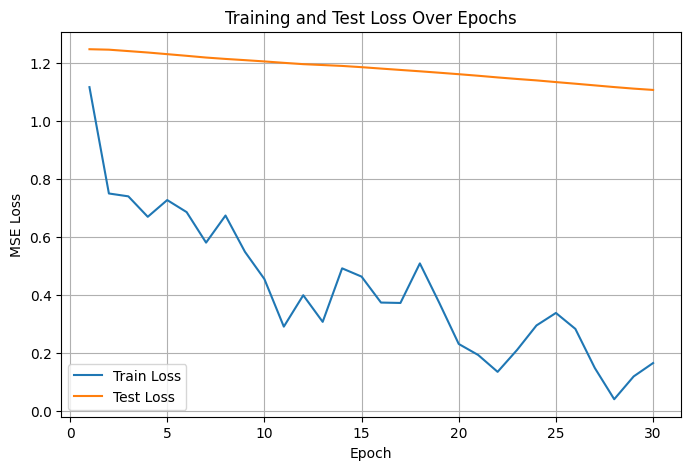

In [ ]:
# Plot losses
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Evaluate on test set & plot predicted vs actual
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    preds_scaled = model(X_test_tensor).cpu().numpy()
    preds = scaler_y.inverse_transform(preds_scaled.reshape(-1,1)).flatten()
    actuals = scaler_y.inverse_transform(y_test.reshape(-1,1)).flatten()


In [ ]:
# R^2 score
r2 = r2_score(actuals, preds)
print(f"R² score on test set: {r2:.4f}")

R² score on test set: nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


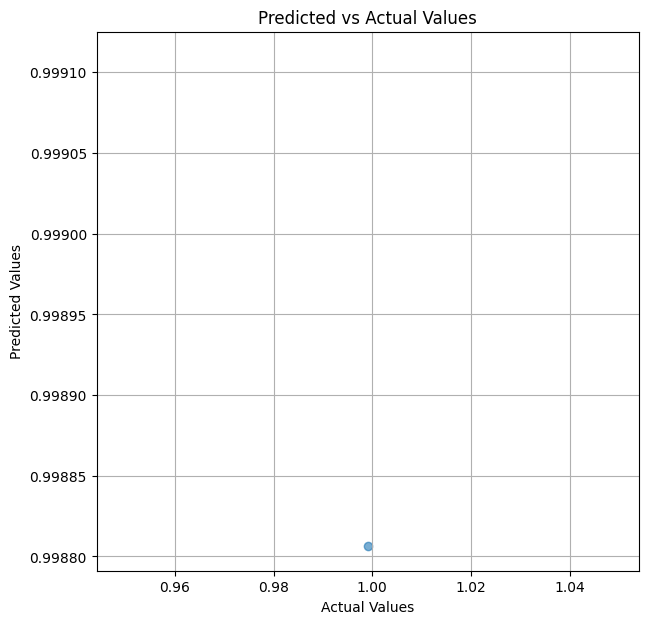

In [ ]:
# Scatter plot predicted vs actual
plt.figure(figsize=(7,7))
plt.scatter(actuals, preds, alpha=0.6)
plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.grid(True)
plt.show()

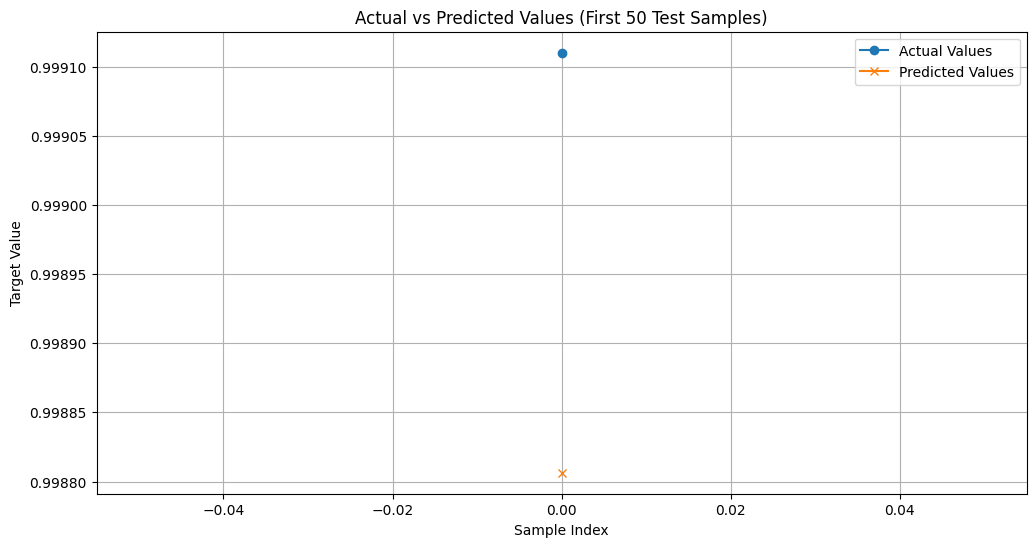

In [ ]:
# Line plot first 50 predicted vs actual
num_points = min(50, len(actuals))
plt.figure(figsize=(12,6))
plt.plot(range(num_points), actuals[:num_points], label='Actual Values', marker='o')
plt.plot(range(num_points), preds[:num_points], label='Predicted Values', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.title('Actual vs Predicted Values (First 50 Test Samples)')
plt.legend()
plt.grid(True)
plt.show()

# FNN (Feedforward Neural Network) [Random Youtube Video]

In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

%matplotlib inline

from google.colab import files
uploaded = files.upload()

filename = list(uploaded.keys())[0]
print(f"Uploaded file: {filename}")

# Load CSV and remove last NaN column
df = pd.read_csv(filename)
print("Original dataset shape:", df.shape)

df = df.iloc[:, :-1]  # remove last NaN column
print("Shape after removing last column:", df.shape)

# Use new last column as target
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values.astype(float)

print(f"Features shape: {X.shape}, Target shape: {y.shape}")

Saving csv_a_0_b_30_c_1.csv to csv_a_0_b_30_c_1 (3).csv
Uploaded file: csv_a_0_b_30_c_1 (3).csv
Original dataset shape: (3, 301)
Shape after removing last column: (3, 300)
Features shape: (3, 299), Target shape: (3,)


In [ ]:
# Standardize features and target
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

In [ ]:
# Use 30% test size to ensure enough test samples (fix for small datasets)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.3, random_state=42)

print(f"Train samples: {len(y_train)}, Test samples: {len(y_test)}")

Train samples: 2, Test samples: 1


In [ ]:
# Dataset class
class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = RegressionDataset(X_train, y_train)
test_dataset = RegressionDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [ ]:
# Fully Connected Feedforward Neural Network for Regression
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim):
        super(FeedforwardNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.layer2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.output_layer = nn.Linear(64, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.output_layer(x)
        return x.squeeze(1)

input_dim = X_scaled.shape[1]
model = FeedforwardNN(input_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# Training loop
num_epochs = 30
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)
    avg_train_loss = running_train_loss / len(train_dataset)

    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_test_loss += loss.item() * inputs.size(0)
    avg_test_loss = running_test_loss / len(test_dataset)

    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.6f} - Test Loss: {avg_test_loss:.6f}")

Epoch 1/30 - Train Loss: 0.936658 - Test Loss: 0.905640
Epoch 2/30 - Train Loss: 1.164328 - Test Loss: 0.903669
Epoch 3/30 - Train Loss: 0.847506 - Test Loss: 0.902219
Epoch 4/30 - Train Loss: 1.042679 - Test Loss: 0.899056
Epoch 5/30 - Train Loss: 0.775403 - Test Loss: 0.895591
Epoch 6/30 - Train Loss: 0.835697 - Test Loss: 0.891125
Epoch 7/30 - Train Loss: 1.142073 - Test Loss: 0.886544
Epoch 8/30 - Train Loss: 0.844926 - Test Loss: 0.882459
Epoch 9/30 - Train Loss: 0.989685 - Test Loss: 0.878867
Epoch 10/30 - Train Loss: 0.843018 - Test Loss: 0.874419
Epoch 11/30 - Train Loss: 0.963242 - Test Loss: 0.869673
Epoch 12/30 - Train Loss: 0.782293 - Test Loss: 0.864722
Epoch 13/30 - Train Loss: 0.802455 - Test Loss: 0.860421
Epoch 14/30 - Train Loss: 0.551234 - Test Loss: 0.856555
Epoch 15/30 - Train Loss: 0.841626 - Test Loss: 0.853397
Epoch 16/30 - Train Loss: 0.785225 - Test Loss: 0.850555
Epoch 17/30 - Train Loss: 0.506871 - Test Loss: 0.847408
Epoch 18/30 - Train Loss: 0.592910 - Tes

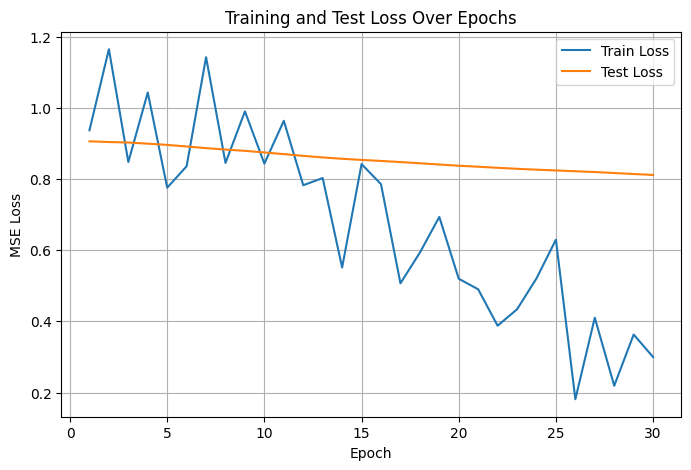

In [ ]:
# Plot training and test loss
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Evaluate model and calculate R² if test set has enough samples
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    preds_scaled = model(X_test_tensor).cpu().numpy()
    preds = scaler_y.inverse_transform(preds_scaled.reshape(-1, 1)).flatten()
    actuals = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

print(f"Test set size: {len(y_test)}")
if len(y_test) > 1:
    r2 = r2_score(actuals, preds)
    print(f"R² score on test set: {r2:.4f}")
else:
    print("Test set too small to compute R² score.")

Test set size: 1
Test set too small to compute R² score.


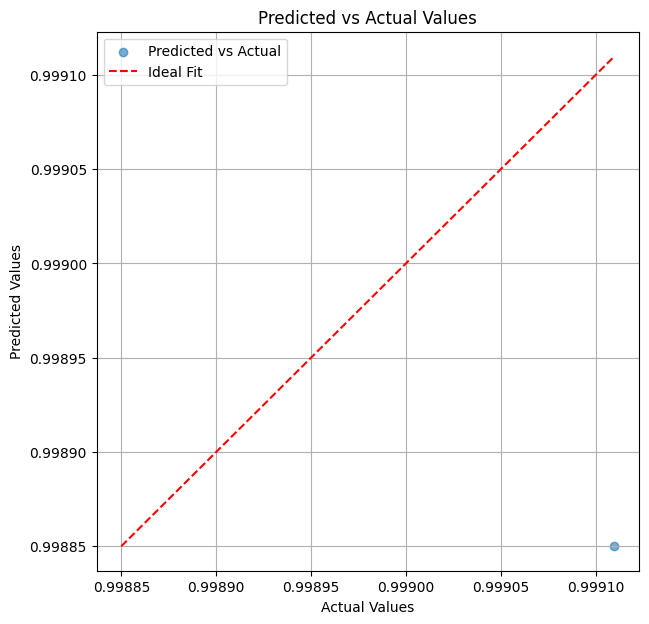

In [ ]:
# Plot predicted vs actual values (scatter)
if len(actuals) > 0 and len(preds) > 0:
    plt.figure(figsize=(7,7))
    plt.scatter(actuals, preds, alpha=0.6, label='Predicted vs Actual')
    min_val = min(actuals.min(), preds.min())
    max_val = max(actuals.max(), preds.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Fit')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Predicted vs Actual Values')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Warning: Empty arrays for actual or predicted values — cannot plot.")

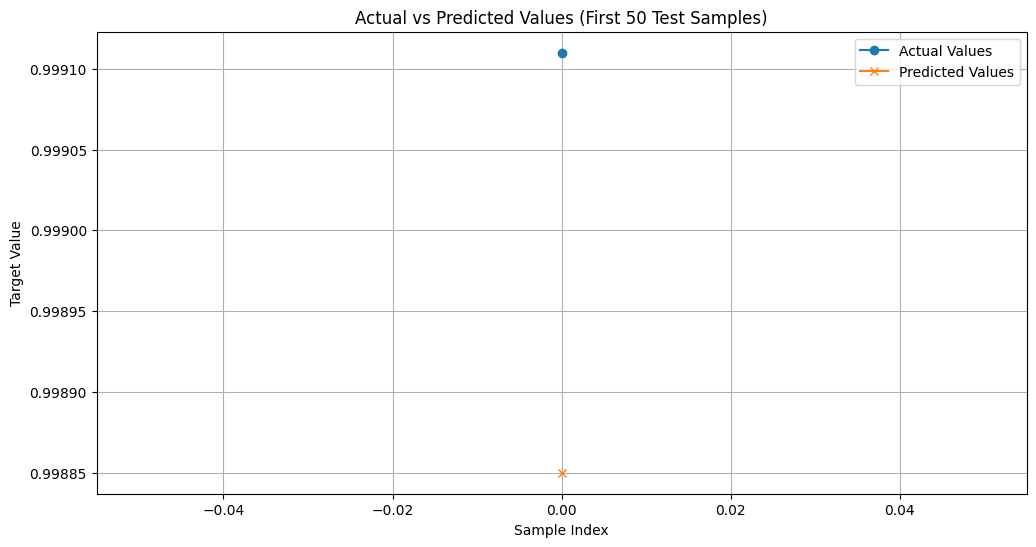

In [ ]:
# Plot first 50 predicted vs actual values (line plot)
num_points = min(50, len(actuals))
if num_points > 0:
    plt.figure(figsize=(12,6))
    plt.plot(range(num_points), actuals[:num_points], label='Actual Values', marker='o')
    plt.plot(range(num_points), preds[:num_points], label='Predicted Values', marker='x')
    plt.xlabel('Sample Index')
    plt.ylabel('Target Value')
    plt.title('Actual vs Predicted Values (First 50 Test Samples)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Warning: No data points available to plot actual vs predicted values.")

# 1D CNN

In [ ]:
!pip install torch --quiet
!pip install matplotlib --quiet
!pip install pandas --quiet

import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from google.colab import files

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.5 MB/s eta 0:00:00


In [ ]:
# Upload CSV files manually
print("Please upload absorption CSV file (with NaNs in last column)...")
uploaded_abs = files.upload()
abs_filename = list(uploaded_abs.keys())[0]

print("Please upload angle CSV file...")
uploaded_angle = files.upload()
angle_filename = list(uploaded_angle.keys())[0]

Please upload absorption CSV file (with NaNs in last column)...


Saving csv_a_0_b_35_c_1.csv to csv_a_0_b_35_c_1.csv
Please upload angle CSV file...


Saving csv_angle.csv to csv_angle (8).csv


In [ ]:
# Load dataframes
df_abs = pd.read_csv(io.BytesIO(uploaded_abs[abs_filename]))
df_angle = pd.read_csv(io.BytesIO(uploaded_angle[angle_filename]), header=None)

# Remove last column from absorption data because it contains NaNs
df_abs = df_abs.iloc[:, :-1]

# Remove last column from angles data as well
df_angle = df_angle.iloc[:, :-1]

# Extract angles array from df_angle
angles = df_angle.values.flatten()

print(f"Absorption data shape after removing last NaN column: {df_abs.shape}")
print(f"Angle data shape after removing last column: {df_angle.shape}")
print(f"Number of angles: {len(angles)}")

# Select a single row for input and target
row_idx = 0
# Input: all absorption points except last point
input_data = df_abs.iloc[row_idx, :-1].values.astype(np.float32)
# Target: absorption points shifted by one (from second column to last)
target_data = df_abs.iloc[row_idx, 1:].values.astype(np.float32)

print(f"Input shape: {input_data.shape}, Target shape: {target_data.shape}")

Absorption data shape after removing last NaN column: (3, 300)
Angle data shape after removing last column: (1, 300)
Number of angles: 300
Input shape: (299,), Target shape: (299,)


In [ ]:
# Convert numpy arrays to PyTorch tensors and add batch and channel dims
# Shape: (batch=1, channels=1, length)
x = torch.tensor(input_data).unsqueeze(0).unsqueeze(0)
y = torch.tensor(target_data).unsqueeze(0).unsqueeze(0)

In [ ]:
# Define the 1D CNN model
class Simple1DCNN(nn.Module):
    def __init__(self):
        super(Simple1DCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(32, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)  # No activation (regression output)
        return x

In [ ]:
# Instantiate model, loss function and optimizer
model = Simple1DCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Training loop
epochs = 300
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(x)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {loss.item():.6f}")

Epoch [50/300] Loss: 0.000017
Epoch [100/300] Loss: 0.000016
Epoch [150/300] Loss: 0.000016
Epoch [200/300] Loss: 0.000016
Epoch [250/300] Loss: 0.000015
Epoch [300/300] Loss: 0.000015


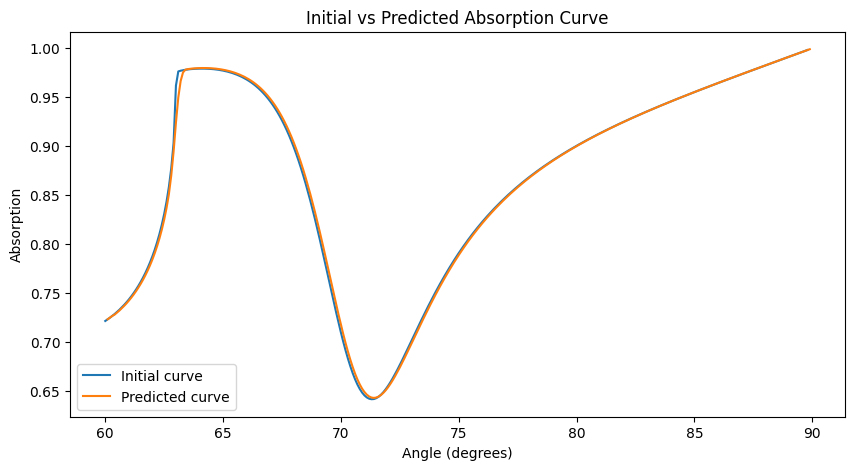

In [ ]:
model.eval()
with torch.no_grad():
    pred = model(x).squeeze().numpy()

plt.figure(figsize=(10, 5))
plt.plot(angles[:-1], input_data, label='Initial curve')
plt.plot(angles[1:], pred, label='Predicted curve')
plt.xlabel('Angle (degrees)')
plt.ylabel('Absorption')
plt.title('Initial vs Predicted Absorption Curve')
plt.legend()
plt.show()

Augmentation

In [ ]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from google.colab import files

# Upload CSV files manually
print("Please upload absorption CSV file (with NaNs in last column)...")
uploaded_abs = files.upload()
abs_filename = list(uploaded_abs.keys())[0]

print("Please upload angle CSV file...")
uploaded_angle = files.upload()
angle_filename = list(uploaded_angle.keys())[0]

Please upload absorption CSV file (with NaNs in last column)...


Saving csv_a_0_b_35_c_1.csv to csv_a_0_b_35_c_1 (1).csv
Please upload angle CSV file...


Saving csv_angle.csv to csv_angle (9).csv


In [ ]:
# Load dataframes
df_abs = pd.read_csv(io.BytesIO(uploaded_abs[abs_filename]))
df_angle = pd.read_csv(io.BytesIO(uploaded_angle[angle_filename]), header=None)

# Remove last column from absorption data because it contains NaNs
df_abs = df_abs.iloc[:, :-1]

# Remove last column from angles data as well
df_angle = df_angle.iloc[:, :-1]

# Extract angles array from df_angle
angles = df_angle.values.flatten()

print(f"Absorption data shape after removing last NaN column: {df_abs.shape}")
print(f"Angle data shape after removing last column: {df_angle.shape}")
print(f"Number of angles: {len(angles)}")

# Select one row index to work with
row_idx = 0

# Original clean curve (target)
clean_curve = df_abs.iloc[row_idx, :].values.astype(np.float32)

# Add Gaussian noise to original curve for augmentation
noise_std = 0.05 * np.max(clean_curve)  # noise std dev = 5% of max value
noise = np.random.normal(0, noise_std, size=clean_curve.shape).astype(np.float32)
noisy_curve = clean_curve + noise

# Clip noisy values to non-negative if needed
noisy_curve = np.clip(noisy_curve, a_min=0, a_max=None)

# Prepare input (noisy) and target (clean)
# Both need to be torch tensors with shape (batch=1, channels=1, length)
x = torch.tensor(noisy_curve).unsqueeze(0).unsqueeze(0)
y = torch.tensor(clean_curve).unsqueeze(0).unsqueeze(0)

Absorption data shape after removing last NaN column: (3, 300)
Angle data shape after removing last column: (1, 300)
Number of angles: 300


In [ ]:
# Define simple 1D CNN model
class Simple1DCNN(nn.Module):
    def __init__(self):
        super(Simple1DCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(32, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [ ]:
# Instantiate model, loss, optimizer
model = Simple1DCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Training loop
epochs = 300
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(x)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")

Epoch [50/300], Loss: 0.000425
Epoch [100/300], Loss: 0.000425
Epoch [150/300], Loss: 0.000424
Epoch [200/300], Loss: 0.000424
Epoch [250/300], Loss: 0.000424
Epoch [300/300], Loss: 0.000424


In [ ]:
# Predict on noisy input
model.eval()
with torch.no_grad():
    pred_curve = model(x).squeeze().numpy()

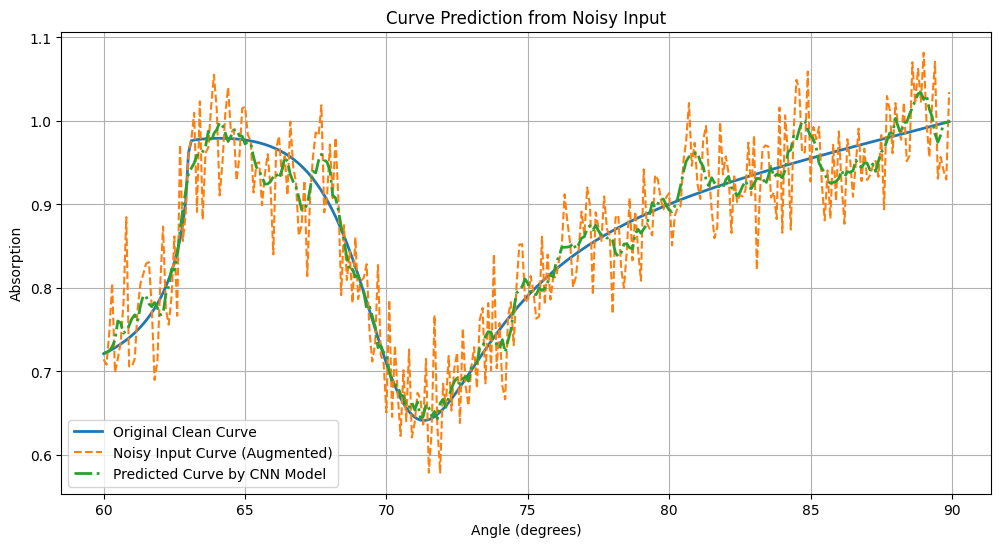

In [ ]:
# Plot original, noisy, and predicted curves
plt.figure(figsize=(12,6))
plt.plot(angles, clean_curve, label='Original Clean Curve', linewidth=2)
plt.plot(angles, noisy_curve, label='Noisy Input Curve (Augmented)', linestyle='--')
plt.plot(angles, pred_curve, label='Predicted Curve by CNN Model', linestyle='-.', linewidth=2)
plt.xlabel('Angle (degrees)')
plt.ylabel('Absorption')
plt.title('Curve Prediction from Noisy Input')
plt.legend()
plt.grid(True)
plt.show()

# LSTM


In [ ]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from google.colab import files

# Upload CSV files manually
print("Please upload absorption CSV file (with NaNs in last column)...")
uploaded_abs = files.upload()
abs_filename = list(uploaded_abs.keys())[0]

print("Please upload angle CSV file...")
uploaded_angle = files.upload()
angle_filename = list(uploaded_angle.keys())[0]

Please upload absorption CSV file (with NaNs in last column)...


Saving csv_a_0_b_35_c_1.csv to csv_a_0_b_35_c_1 (2).csv
Please upload angle CSV file...


Saving csv_angle.csv to csv_angle (10).csv


In [ ]:
# Load dataframes
df_abs = pd.read_csv(io.BytesIO(uploaded_abs[abs_filename]))
df_angle = pd.read_csv(io.BytesIO(uploaded_angle[angle_filename]), header=None)

# Remove last column from absorption data because it contains NaNs
df_abs = df_abs.iloc[:, :-1]

# Remove last column from angles data as well
df_angle = df_angle.iloc[:, :-1]

# Extract angles array from df_angle
angles = df_angle.values.flatten()

print(f"Absorption data shape after removing last NaN column: {df_abs.shape}")
print(f"Angle data shape after removing last column: {df_angle.shape}")
print(f"Number of angles: {len(angles)}")

Absorption data shape after removing last NaN column: (3, 300)
Angle data shape after removing last column: (1, 300)
Number of angles: 300


In [ ]:
# Select one row index to work with
row_idx = 0

# Original clean curve (target)
clean_curve = df_abs.iloc[row_idx, :].values.astype(np.float32)

# Add Gaussian noise to original curve for augmentation
noise_std = 0.05 * np.max(clean_curve)  # noise std dev = 5% of max value
noise = np.random.normal(0, noise_std, size=clean_curve.shape).astype(np.float32)
noisy_curve = clean_curve + noise
noisy_curve = np.clip(noisy_curve, 0, None)  # no negative values

# Convert sequences to torch tensors with shape (seq_len, batch, features)
# Here batch=1, features=1 (single value at each timestep)
x = torch.tensor(noisy_curve).view(-1, 1, 1)
y = torch.tensor(clean_curve).view(-1, 1, 1)

In [ ]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: (seq_len, batch, hidden_size)

        # Decode the hidden state of the last layer at each time step
        out = self.linear(out)  # (seq_len, batch, output_size)
        return out

In [ ]:
# Instantiate model, loss function and optimizer
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Training loop
epochs = 300
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(x)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")

Epoch [50/300], Loss: 0.000128
Epoch [100/300], Loss: 0.000183
Epoch [150/300], Loss: 0.000124
Epoch [200/300], Loss: 0.000125
Epoch [250/300], Loss: 0.000137
Epoch [300/300], Loss: 0.000128


In [ ]:
# Evaluation
model.eval()
with torch.no_grad():
    pred = model(x).squeeze().numpy()

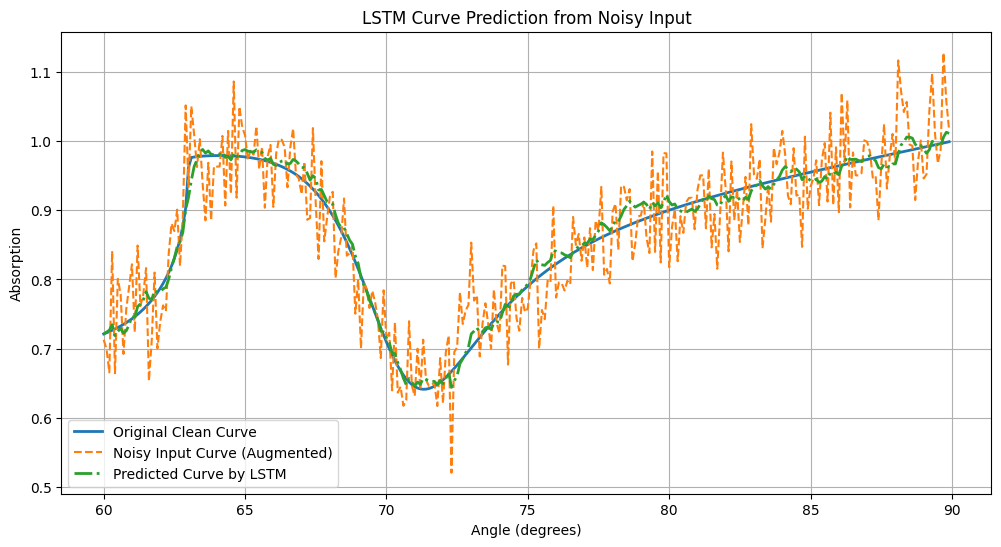

In [ ]:
# Plot original, noisy and predicted curves
plt.figure(figsize=(12, 6))
plt.plot(angles, clean_curve, label='Original Clean Curve', linewidth=2)
plt.plot(angles, noisy_curve, label='Noisy Input Curve (Augmented)', linestyle='--')
plt.plot(angles, pred, label='Predicted Curve by LSTM', linestyle='-.', linewidth=2)
plt.xlabel('Angle (degrees)')
plt.ylabel('Absorption')
plt.title('LSTM Curve Prediction from Noisy Input')
plt.legend()
plt.grid(True)
plt.show()

# RNN

In [ ]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from google.colab import files

# Upload CSV files manually
print("Please upload absorption CSV file (with NaNs in last column)...")
uploaded_abs = files.upload()
abs_filename = list(uploaded_abs.keys())[0]

print("Please upload angle CSV file...")
uploaded_angle = files.upload()
angle_filename = list(uploaded_angle.keys())[0]

Please upload absorption CSV file (with NaNs in last column)...


Saving csv_a_0_b_35_c_1.csv to csv_a_0_b_35_c_1 (3).csv
Please upload angle CSV file...


Saving csv_angle.csv to csv_angle (11).csv


In [ ]:
# Load dataframes
df_abs = pd.read_csv(io.BytesIO(uploaded_abs[abs_filename]))
df_angle = pd.read_csv(io.BytesIO(uploaded_angle[angle_filename]), header=None)

# Remove last column from absorption data because it contains NaNs
df_abs = df_abs.iloc[:, :-1]

# Remove last column from angles data as well
df_angle = df_angle.iloc[:, :-1]

# Extract angles array from df_angle
angles = df_angle.values.flatten()

print(f"Absorption data shape after removing last NaN column: {df_abs.shape}")
print(f"Angle data shape after removing last column: {df_angle.shape}")
print(f"Number of angles: {len(angles)}")

Absorption data shape after removing last NaN column: (3, 300)
Angle data shape after removing last column: (1, 300)
Number of angles: 300


In [ ]:
# Select one row index to work with
row_idx = 0

# Original clean curve (target)
clean_curve = df_abs.iloc[row_idx, :].values.astype(np.float32)

# Add Gaussian noise to original curve for augmentation
noise_std = 0.05 * np.max(clean_curve)  # noise std dev = 5% of max value
noise = np.random.normal(0, noise_std, size=clean_curve.shape).astype(np.float32)
noisy_curve = clean_curve + noise
noisy_curve = np.clip(noisy_curve, 0, None)  # no negative values

# Convert sequences to torch tensors with shape (seq_len, batch, features)
# Here batch=1, features=1 (single value at each timestep)
x = torch.tensor(noisy_curve).view(-1, 1, 1)
y = torch.tensor(clean_curve).view(-1, 1, 1)

In [ ]:
# Define RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_size=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(input_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.linear(out)
        return out

In [ ]:
# Instantiate model, loss function and optimizer
model = RNNModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Training loop
epochs = 300
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(x)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")

Epoch [50/300], Loss: 0.006389
Epoch [100/300], Loss: 0.001629
Epoch [150/300], Loss: 0.005394
Epoch [200/300], Loss: 0.002340
Epoch [250/300], Loss: 0.001485
Epoch [300/300], Loss: 0.000579


In [ ]:
# Evaluation
model.eval()
with torch.no_grad():
    pred = model(x).squeeze().numpy()

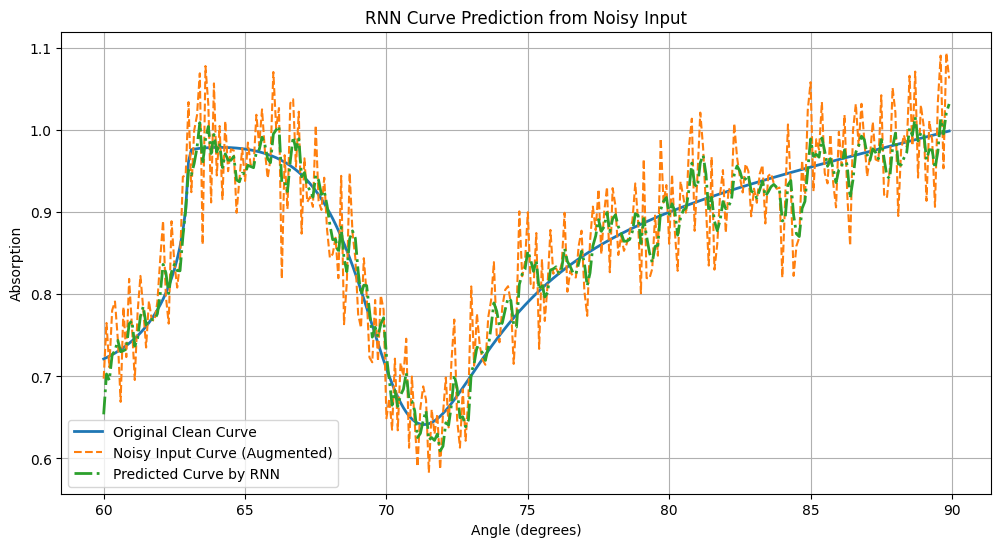

In [ ]:
# Plot original, noisy and predicted curves
plt.figure(figsize=(12, 6))
plt.plot(angles[:len(clean_curve)], clean_curve, label='Original Clean Curve', linewidth=2)
plt.plot(angles[:len(noisy_curve)], noisy_curve, label='Noisy Input Curve (Augmented)', linestyle='--')
plt.plot(angles[:len(pred)], pred, label='Predicted Curve by RNN', linestyle='-.', linewidth=2)

plt.xlabel('Angle (degrees)')
plt.ylabel('Absorption')
plt.title('RNN Curve Prediction from Noisy Input')
plt.legend()
plt.grid(True)
plt.show()

# Comparison

Please upload 4 absorption CSV files for 4 different materials (with NaNs in last column)...


Saving csv_a_0_b_35_c_1.csv to csv_a_0_b_35_c_1 (6).csv
Saving csv_a_0_b_30_c_3.csv to csv_a_0_b_30_c_3 (6).csv
Saving csv_a_0_b_30_c_2.csv to csv_a_0_b_30_c_2 (7).csv
Saving csv_a_0_b_30_c_1.csv to csv_a_0_b_30_c_1 (5).csv
Please upload angle CSV file...


Saving csv_angle.csv to csv_angle (14).csv


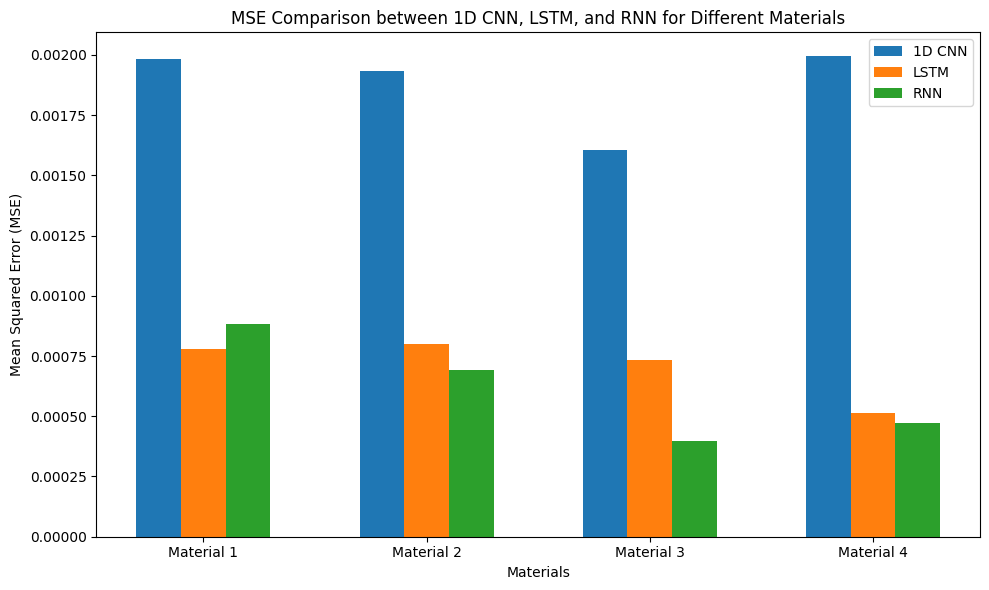

In [ ]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from google.colab import files

# Upload CSV files for 4 materials and 1 angle CSV manually
print("Please upload 4 absorption CSV files for 4 different materials (with NaNs in last column)...")
uploaded_abs = files.upload()
abs_filenames = list(uploaded_abs.keys())  # This will be a list of 4 material CSVs

print("Please upload angle CSV file...")
uploaded_angle = files.upload()
angle_filename = list(uploaded_angle.keys())[0]

# Load angle data (common for all materials)
df_angle = pd.read_csv(io.BytesIO(uploaded_angle[angle_filename]), header=None)
angles = df_angle.values.flatten()

# Define function to load data for each material
def load_data_for_material(filename):
    df = pd.read_csv(io.BytesIO(uploaded_abs[filename]))
    df = df.iloc[:, :-1]  # Remove the last column containing NaNs
    return df

# Load absorption data for all 4 materials
materials_data = [load_data_for_material(f) for f in abs_filenames]

# Define the models (1D CNN, LSTM, RNN)
class Simple1DCNN(nn.Module):
    def __init__(self):
        super(Simple1DCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(32, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.linear(out)
        return out

class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_size=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.linear(out)
        return out

# Function to add noise to the absorption data for augmentation
def add_noise_to_curve(curve, noise_std_ratio=0.05):
    noise_std = noise_std_ratio * np.max(curve)
    noise = np.random.normal(0, noise_std, size=curve.shape)
    noisy_curve = curve + noise
    noisy_curve = np.clip(noisy_curve, 0, None)  # no negative values
    return noisy_curve

# Function to prepare data for training (convert noisy curve and clean curve to tensors)
def prepare_data_for_training(clean_curve, noisy_curve):
    x = torch.tensor(noisy_curve, dtype=torch.float32).view(-1, 1, 1)
    y = torch.tensor(clean_curve, dtype=torch.float32).view(-1, 1, 1)
    return x, y

# Function to compute Mean Squared Error (MSE)
def compute_mse(pred, target):
    return np.mean((pred - target.squeeze())**2)

# Function to train and evaluate a model
def train_and_evaluate(model, x, y, epochs=300):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        pred = model(x).squeeze().numpy()

    return pred

# Initialize dictionaries to store MSE values for each material and model
mse_values_cnn = []
mse_values_lstm = []
mse_values_rnn = []

# Train and evaluate models for each material
for material_idx, material_data in enumerate(materials_data):
    # Select the first row as the data for training
    clean_curve = material_data.iloc[0, :].values.astype(np.float32)

    # Add noise to the clean curve for augmentation
    noisy_curve = add_noise_to_curve(clean_curve)

    # Prepare data for training
    x, y = prepare_data_for_training(clean_curve, noisy_curve)

    # Initialize models
    cnn_model = Simple1DCNN()
    lstm_model = LSTMModel()
    rnn_model = RNNModel()

    # Train and evaluate each model
    cnn_pred = train_and_evaluate(cnn_model, x, y)
    lstm_pred = train_and_evaluate(lstm_model, x, y)
    rnn_pred = train_and_evaluate(rnn_model, x, y)

    # Compute MSE for each model
    cnn_mse = compute_mse(cnn_pred, clean_curve)
    lstm_mse = compute_mse(lstm_pred, clean_curve)
    rnn_mse = compute_mse(rnn_pred, clean_curve)

    # Append MSE values for each model to the lists
    mse_values_cnn.append(cnn_mse)
    mse_values_lstm.append(lstm_mse)
    mse_values_rnn.append(rnn_mse)

# Create a bar plot for MSE comparison of all models across 4 materials
labels = [f'Material {i+1}' for i in range(4)]

x = np.arange(len(labels))  # Material positions
width = 0.2  # Bar width

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each model
ax.bar(x - width, mse_values_cnn, width, label='1D CNN')
ax.bar(x, mse_values_lstm, width, label='LSTM')
ax.bar(x + width, mse_values_rnn, width, label='RNN')

# Labeling the plot
ax.set_xlabel('Materials')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('MSE Comparison between 1D CNN, LSTM, and RNN for Different Materials')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()


Please upload 4 absorption CSV files for 4 different materials (with NaNs in last column)...


Saving csv_a_0_b_35_c_1.csv to csv_a_0_b_35_c_1.csv
Saving csv_a_0_b_30_c_3.csv to csv_a_0_b_30_c_3.csv
Saving csv_a_0_b_30_c_2.csv to csv_a_0_b_30_c_2.csv
Saving csv_a_0_b_30_c_1.csv to csv_a_0_b_30_c_1.csv
Please upload angle CSV file...


Saving csv_angle.csv to csv_angle.csv


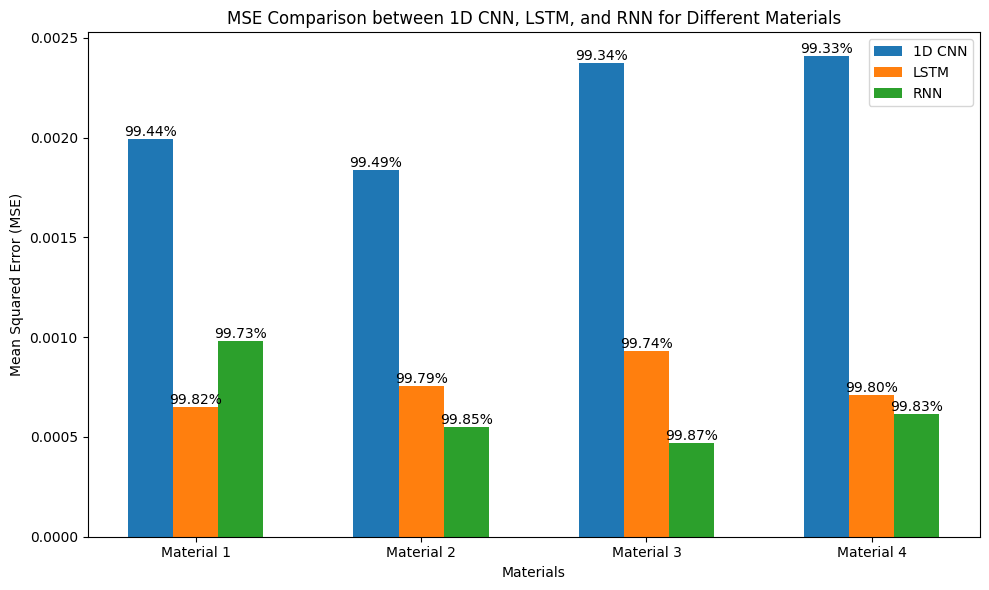

In [ ]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from google.colab import files

# Upload CSV files for 4 materials and 1 angle CSV manually
print("Please upload 4 absorption CSV files for 4 different materials (with NaNs in last column)...")
uploaded_abs = files.upload()
abs_filenames = list(uploaded_abs.keys())  # This will be a list of 4 material CSVs

print("Please upload angle CSV file...")
uploaded_angle = files.upload()
angle_filename = list(uploaded_angle.keys())[0]

# Load angle data (common for all materials)
df_angle = pd.read_csv(io.BytesIO(uploaded_angle[angle_filename]), header=None)
angles = df_angle.values.flatten()

# Define function to load data for each material
def load_data_for_material(filename):
    df = pd.read_csv(io.BytesIO(uploaded_abs[filename]))
    df = df.iloc[:, :-1]  # Remove the last column containing NaNs
    return df

# Load absorption data for all 4 materials
materials_data = [load_data_for_material(f) for f in abs_filenames]

# Define the models (1D CNN, LSTM, RNN)
class Simple1DCNN(nn.Module):
    def __init__(self):
        super(Simple1DCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(32, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.linear(out)
        return out

class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_size=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.linear(out)
        return out

# Function to add noise to the absorption data for augmentation
def add_noise_to_curve(curve, noise_std_ratio=0.05):
    noise_std = noise_std_ratio * np.max(curve)
    noise = np.random.normal(0, noise_std, size=curve.shape)
    noisy_curve = curve + noise
    noisy_curve = np.clip(noisy_curve, 0, None)  # no negative values
    return noisy_curve

# Function to prepare data for training (convert noisy curve and clean curve to tensors)
def prepare_data_for_training(clean_curve, noisy_curve):
    x = torch.tensor(noisy_curve, dtype=torch.float32).view(-1, 1, 1)
    y = torch.tensor(clean_curve, dtype=torch.float32).view(-1, 1, 1)
    return x, y

# Function to compute Mean Squared Error (MSE)
def compute_mse(pred, target):
    return np.mean((pred - target.squeeze())**2)

# Function to compute accuracy from MSE
def compute_accuracy(mse, curve):
    max_mse = np.max(curve) - np.min(curve)
    accuracy = 100 * (1 - mse / max_mse)  # Convert to percentage
    return accuracy

# Function to train and evaluate a model
def train_and_evaluate(model, x, y, epochs=300):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        pred = model(x).squeeze().numpy()

    return pred

# Initialize dictionaries to store MSE values and accuracy percentages for each material and model
mse_values_cnn = []
mse_values_lstm = []
mse_values_rnn = []
accuracy_cnn = []
accuracy_lstm = []
accuracy_rnn = []

# Train and evaluate models for each material
for material_idx, material_data in enumerate(materials_data):
    # Select the first row as the data for training
    clean_curve = material_data.iloc[0, :].values.astype(np.float32)

    # Add noise to the clean curve for augmentation
    noisy_curve = add_noise_to_curve(clean_curve)

    # Prepare data for training
    x, y = prepare_data_for_training(clean_curve, noisy_curve)

    # Initialize models
    cnn_model = Simple1DCNN()
    lstm_model = LSTMModel()
    rnn_model = RNNModel()

    # Train and evaluate each model
    cnn_pred = train_and_evaluate(cnn_model, x, y)
    lstm_pred = train_and_evaluate(lstm_model, x, y)
    rnn_pred = train_and_evaluate(rnn_model, x, y)

    # Compute MSE for each model
    cnn_mse = compute_mse(cnn_pred, clean_curve)
    lstm_mse = compute_mse(lstm_pred, clean_curve)
    rnn_mse = compute_mse(rnn_pred, clean_curve)

    # Compute accuracy percentage for each model
    cnn_accuracy = compute_accuracy(cnn_mse, clean_curve)
    lstm_accuracy = compute_accuracy(lstm_mse, clean_curve)
    rnn_accuracy = compute_accuracy(rnn_mse, clean_curve)

    # Append MSE values for each model to the lists
    mse_values_cnn.append(cnn_mse)
    mse_values_lstm.append(lstm_mse)
    mse_values_rnn.append(rnn_mse)

    # Append accuracy percentages for each model to the lists
    accuracy_cnn.append(cnn_accuracy)
    accuracy_lstm.append(lstm_accuracy)
    accuracy_rnn.append(rnn_accuracy)

# Create a bar plot for MSE comparison of all models across 4 materials
labels = [f'Material {i+1}' for i in range(4)]

x = np.arange(len(labels))  # Material positions
width = 0.2  # Bar width

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each model
ax.bar(x - width, mse_values_cnn, width, label='1D CNN')
ax.bar(x, mse_values_lstm, width, label='LSTM')
ax.bar(x + width, mse_values_rnn, width, label='RNN')

# Labeling the plot
ax.set_xlabel('Materials')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('MSE Comparison between 1D CNN, LSTM, and RNN for Different Materials')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add accuracy percentage text on top of each bar
for i, material in enumerate(labels):
    ax.text(x[i] - width, mse_values_cnn[i], f'{accuracy_cnn[i]:.2f}%', ha='center', va='bottom')
    ax.text(x[i], mse_values_lstm[i], f'{accuracy_lstm[i]:.2f}%', ha='center', va='bottom')
    ax.text(x[i] + width, mse_values_rnn[i], f'{accuracy_rnn[i]:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()
